# How to train an machine learning model

The following tutorial is an `eo-grow` adaptation of the `eo-learn` [LULC tutorial](https://eo-learn.readthedocs.io/en/latest/examples/land-cover-map/SI_LULC_pipeline.html). By comparing the two we can see how `eo-grow` removes boilerplate code and takes care of automation and parallelization of EO workflows.

Within this example, we will download Sentinel 2 data, a Land-Use-Land-Cover reference dataset, and train a LightGBM classifier for prediction of LULC classes from time-series.

The tutorial requires the ML installation `eo-grow[ML]` and a working Sentinel Hub account.

While this notebook shows how to execute the pipeline interactively within a Jupyter notebook, the same pipelines can be  programatically run via the CLI. To do so, save the configuration files for each pipeline as JSON files and execute `eogrow config.json`. The pipelines can also be chained in a single JSON file and the entire workflow can be run in a single CLI command.

In [ ]:
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import ray
import requests
import shapely
from matplotlib.colors import BoundaryNorm, ListedColormap

from eolearn.core import EOPatch, FeatureType

### Preparations

Before we start processing with `eo-grow` we must first prepare some files:

- Decide the folder where all the files from the project will be kept.
- Download the reference dataset.
- Establish what the area-of-interest (AOI) is. For this example we'll process the whole area for which we have reference data (results in 12 eopatches with 1000x1000 px images).
- We also decide to use the same time-of-interest (TOI) as the `eo-learn` example, the whole year of 2019.

We store the AOI and reference data in a special folder named `input-data`. While most of the folder structure is defined by the user, there are certain folders that are pre-defined. The `input-data` folder is meant to contain files that we cannot obtain via `eo-grow`, in our case the AOI file and the reference dataset.

In [2]:
# establish project folder where all the files are saved
PROJECT_FOLDER = Path("./lulc_project")
INPUT_DATA_PATH = PROJECT_FOLDER / "input-data"

# create folders
INPUT_DATA_PATH.mkdir(parents=True, exist_ok=True)

# define TOI and other parameters
TOI = ["2019-01-01", "2019-12-31"]
RESOLUTION = 10  # 10m resolution
BAND_NAMES = ["B02", "B03", "B04", "B08", "B11", "B12"]  # same subset as in eo-learn example

In [3]:
# download reference data
url = "http://eo-learn.sentinel-hub.com.s3.eu-central-1.amazonaws.com/land_use_10class_reference_slovenia_partial.gpkg"
r = requests.get(url, allow_redirects=True)
with open(INPUT_DATA_PATH / "reference.gpkg", "wb") as gpkg:
    gpkg.write(r.content)

In [4]:
# calculate AOI from reference data
reference_gdf = gpd.read_file(INPUT_DATA_PATH / "reference.gpkg")

aoi_bounds = reference_gdf.total_bounds
aoi_geometry = shapely.geometry.box(*aoi_bounds)
aoi_gdf = gpd.GeoDataFrame(geometry=[aoi_geometry], crs=reference_gdf.crs)

# save to geojson
aoi_gdf.to_file(INPUT_DATA_PATH / "aoi.geojson")

### Define project specifics

We configure common parameters that are shared across all pipelines. These are already grouped in [managers](https://eo-grow.readthedocs.io/en/latest/high-level-overview.html#managers).

We write configurations in Python dictionaries. While we could directly construct `Schema` objects, using dictionaries closely mimics JSON-file definitions of pipelines, which is common for larger projects.

In [3]:
area_config = {
    "manager": "eogrow.core.area.UtmZoneAreaManager",  # check the docs for supported AreaManagers
    "geometry_filename": "aoi.geojson",
    "patch": {"size_x": 10000, "size_y": 10000},  # EOPatches will be 10km x 10km, which is 1000px x 1000px
}
logging_config = {
    "manager": "eogrow.core.logging.LoggingManager",
    "save_logs": True,  # save logs in a dedicated folder
    "show_logs": True,  # show logs in CLI/notebook so we can see progress
}
storage_config = {
    "manager": "eogrow.core.storage.StorageManager",
    "project_folder": str(PROJECT_FOLDER),  # where all the files are stored
    "structure": {  # user-defined key: path pairs for identifying subfolders. Here we have a very simple structure
        "downloaded_data": "data/imagery",
        "mosaicked_data": "data/mosaicked",
        "reference": "reference",
        "samples": "samples/eopatches",
        "merged_samples": "samples/merged",
        "models": "models",
        "predictions": "predictions",
    },
}

managers = {  # every pipeline needs these, so we pack them together to pass them in with the ** notation
    "area": area_config,
    "storage": storage_config,
    "logging": logging_config,
}

### Initialize cluster

The parallelization in `eo-grow` is taken care of by `ray`. We must first establish a connection with a cluster. In our case this will spawn a local `ray` cluster on our machine, which behaves similarly to regular multiprocessing.

In [ ]:
ray.init(num_cpus=4)  # restrict number of CPUS to avoid memory issues

## Download and process imagery

We download Sentinel 2 L2A imagery and save the selected bands into a features named `BANDS`. We need to know which pixels are valid so we also save data-mask `dataMask` and the cloud-mask `CLM`.

For this pipeline to run, the Sentinel Hub credentials need to be set-up.

In [7]:
from eogrow.pipelines.download import DownloadPipeline

download_config = dict(
    **managers,
    output_folder_key="downloaded_data",
    bands_feature_name="BANDS",
    bands=BAND_NAMES,
    additional_data=[(FeatureType.MASK, "CLM"), (FeatureType.MASK, "dataMask")],
    data_collection="SENTINEL2_L2A",
    resolution=RESOLUTION,
    maxcc=0.2,
    time_period=TOI,
    use_dn=True,
    threads_per_worker=4,  # to avoid overloading SH
)

download_pipeline = DownloadPipeline.from_raw_config(download_config)

In [ ]:
download_pipeline.run()

We want to remove any invalid points in the data series and make it temporally uniform, which we can achieve with mosaicking.
This is different from the `eo-learn` example where interpolation was used, but `eo-grow` does not have a built-in interpolation pipeline. However you are free to [define your own](https://eo-grow.readthedocs.io/en/latest/high-level-overview.html#pipelines).

In [9]:
from eogrow.pipelines.features import MosaickingFeaturesPipeline

mosaicking_config = dict(
    **managers,
    input_folder_key="downloaded_data",
    bands_feature_name="BANDS",
    output_folder_key="mosaicked_data",
    output_feature_name="FEATURES",
    data_preparation=dict(
        cloud_mask_feature_name="CLM",
        valid_data_feature_name="dataMask",
        validity_threshold=0.8,  # discard any time-frames with not enough suitable data
    ),
    ndis=dict(NDVI=[BAND_NAMES.index("B08"), BAND_NAMES.index("B04")]),
    mosaicking=dict(time_period=TOI, n_mosaics=12),  # make a 'per-month' mosaic
)

mosaicking_pipeline = MosaickingFeaturesPipeline.from_raw_config(mosaicking_config)

In [ ]:
mosaicking_pipeline.run()

## Reference data

Our reference data is currently in vector format and needs to be rasterized into images with the same resolution as the downloaded data.

In [11]:
from eogrow.pipelines.rasterize import RasterizePipeline

rasterization_config = dict(
    **managers,
    input_folder_key="input_data",
    output_folder_key="reference",
    vector_input="reference.gpkg",
    output_feature=(FeatureType.MASK_TIMELESS, "LULC"),
    raster_values_column="lulcid",
    resolution=RESOLUTION,
    no_data_value=0,
)

rasterization_pipeline = RasterizePipeline.from_raw_config(rasterization_config)

In [ ]:
rasterization_pipeline.run()

## Sampling data for model

We took care of no-data and cloudy pixels in the mosaicking step, but our reference data only covers a part of our area. We will sample 50% of points from our data, while ignoring those that are marked as 'no-data'.

In [13]:
from eogrow.pipelines.sampling import FractionSamplingPipeline

rasterization_config = dict(
    **managers,
    output_folder_key="samples",
    apply_to={
        "mosaicked_data": {"data": ["FEATURES"]},
        "reference": {"mask_timeless": ["LULC"]},
    },
    seed=42,
    sampling_feature_name="LULC",
    fraction_of_samples=0.5,  # sample 50% of suitable data
    exclude_values=[0],  # do not sample pixels which are marked as no-data
)

sampling_pipeline = FractionSamplingPipeline.from_raw_config(rasterization_config)

In [ ]:
sampling_pipeline.run()

## Training the model

To train the model we first merge the data into `.npy` files that are then passed to the model-training pipeline.


In [15]:
from eogrow.pipelines.merge_samples import MergeSamplesPipeline

merging_config = dict(
    **managers,
    input_folder_key="samples",
    output_folder_key="merged_samples",
    features_to_merge=[("data", "FEATURES"), ("mask_timeless", "LULC")],
)

merge_pipeline = MergeSamplesPipeline.from_raw_config(merging_config)

In [ ]:
merge_pipeline.run()

In [4]:
from eogrow.pipelines.training import ClassificationTrainingPipeline

merging_config = dict(
    **managers,
    input_folder_key="merged_samples",
    model_folder_key="models",
    model_filename="lulc_model",
    train_features=["FEATURES.npy"],
    train_reference="LULC.npy",
    train_test_split=dict(train_size=0.8),  # keep 20% of data to evaluate model
    model_parameters={"random_state": 42, "n_estimators": 100},  # parameters passed to the model
)

training_pipeline = ClassificationTrainingPipeline.from_raw_config(merging_config)

In [ ]:
training_pipeline.run()

## Sanity check

We want to check that the model trained properly. While the training pipeline offers some statistics, it is best to also visually assess the results.

We run a prediction pipeline to obtain predictions for the whole AOI, and then load an EOPatch in order to compare the reference data and predictions.

In [6]:
from eogrow.pipelines.prediction import ClassificationPredictionPipeline

merging_config = dict(
    **managers,
    input_folder_key="mosaicked_data",
    input_features=[("data", "FEATURES")],
    output_folder_key="predictions",
    output_feature_name="predicted_LULC",
    model_folder_key="models",
    model_filename="lulc_model",
)

prediction_pipeline = ClassificationPredictionPipeline.from_raw_config(merging_config)

In [ ]:
prediction_pipeline.run()

Let's visualize results for one EOPatch

In [10]:
patch_name = "eopatch-id-05-col-1-row-1"

ref_patch = EOPatch.load(PROJECT_FOLDER / "reference" / patch_name)
predicted_patch = EOPatch.load(PROJECT_FOLDER / "predictions" / patch_name)
reference = ref_patch.mask_timeless["LULC"]
prediction = predicted_patch.mask_timeless["predicted_LULC"]

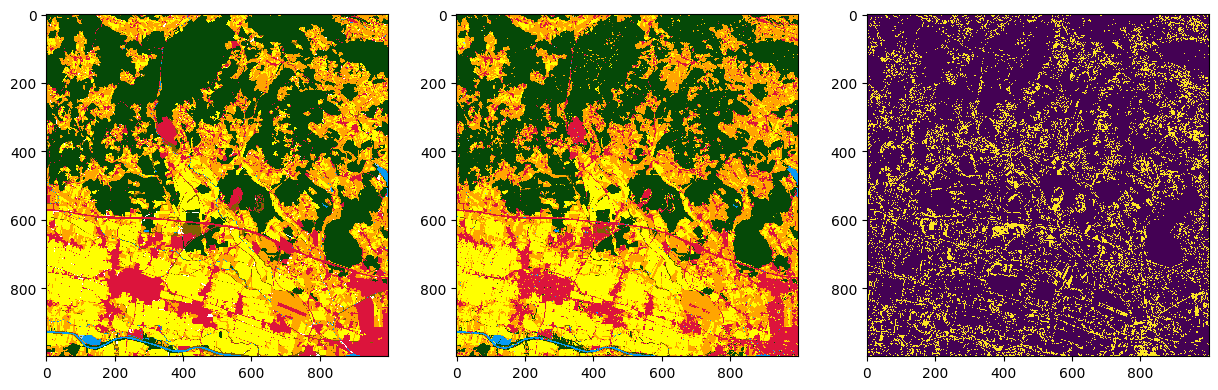

In [11]:
colors = [
    "#ffffff",
    "#ffff00",
    "#054907",
    "#ffa500",
    "#806000",
    "#069af3",
    "#95d0fc",
    "#967bb6",
    "#dc143c",
    "#a6a6a6",
    "#000000",
]
lulc_cmap = ListedColormap(colors, name="lulc_cmap")
lulc_norm = BoundaryNorm([x - 0.5 for x in range(11)], lulc_cmap.N)

figs, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(reference, cmap=lulc_cmap, norm=lulc_norm, interpolation="none")
axs[1].imshow(prediction, cmap=lulc_cmap, norm=lulc_norm, interpolation="none")
axs[2].imshow(reference != prediction, interpolation="none")